In [1]:
import jax
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Sequence, Union
import lib
from sklearn.cluster import KMeans
import sklearn
import optax
from tqdm import tqdm

In [2]:
time_delay_dim = 10
time_delay = 20
time_range = (0, 600, 0.02)
n_centers = 500

In [3]:
# n_points = len(np.arange(*time_range))
# constant_current_duration = 2500
# n_current_plateaus = n_points//constant_current_duration
# np.random.seed(21)
# random_i = np.random.uniform(-15, 60, size=(n_current_plateaus, 1))
# stimulus_list = (np.ones((n_current_plateaus, constant_current_duration))*random_i).reshape((-1, ))
# stimulus = lib.custom_stimulus(stimulus_list=stimulus_list, time_range=time_range, time_constant=10)

# stimulus = lib.lorenz1996_stimulus(N=8, F=6, time_range=time_range, initial_state=[1, 2, 8.01, 4, 8, 5], time_constant=10, rescale_factor=2.)
# stimulus.get_stimulus_list()
rescale_factor = 1
stimulus = lib.lorenz1963_stimulus(time_range=(0, 600, 0.02), rescale_factor=rescale_factor, initial_state=[-3.5, -3.0, 21.])
stimulus.get_stimulus_list()
# tmp1 = stimulus.stimulus_list
# tmp2 = np.ones(30000)*0
# tmp2[:3000] = 15
# tmp2[3000:4000] = 0
# tmp2[4000:7000] = 12
# tmp2[7000:8000] = -2
# tmp2[8000:11000] = 9
# tmp2[11000:14000] = 5
# tmp2[14000:15000] = 10
# tmp2[15000:16000] = -5
# tmp2[16000:19000] = 13
# tmp2[19000:20000] = -10
# tmp2[20000:22000] = 0
# tmp2[22000:26000] = 11
# tmp2[26000:27000] = 3
# tmp2[27000:28000] = -8
# tmp2[28000:29000] = 7

# tmp = np.concatenate((tmp1, tmp2))
# stimulus = lib.custom_stimulus(tmp, time_range=time_range)


# stimulus = lib.constant_stimulus(dc_stimulus=15, time_range=time_range)
# stimulus.get_stimulus_list()

training_neuron = lib.single_neuron_odeint(stimulus, [0, 0, 0, 0])
training_neuron.generate_sol()

In [177]:
drop_first_n_points = 5000
training_neuron.sol = training_neuron.sol[drop_first_n_points:]
stimulus.stimulus_list = stimulus.stimulus_list[drop_first_n_points:]

Text(0, 0.5, 'V(t) exact')

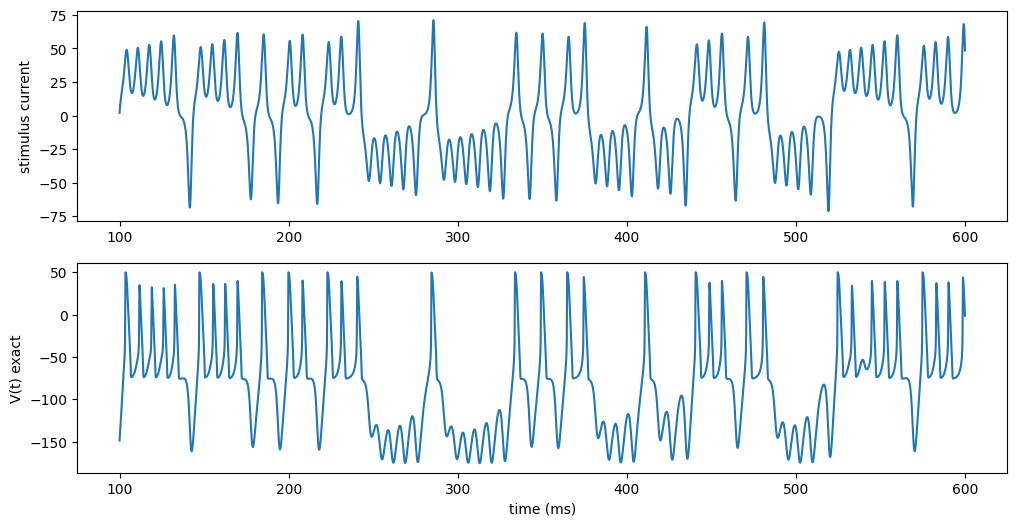

In [178]:
fig, axes = plt.subplots(2, 1,  figsize=(12, 6))

axes[0].plot(np.arange(*time_range)[drop_first_n_points:], stimulus.stimulus_list)
axes[0].set_ylabel("stimulus current")
axes[1].plot(np.arange(*time_range)[drop_first_n_points:], training_neuron.sol[:, 0])
axes[1].set_xlabel("time (ms)")
axes[1].set_ylabel("V(t) exact")

In [179]:
# get points in time delay coordinate and k-means centers
points_time_delay = np.array([np.roll(training_neuron.sol[:, 0], -i*time_delay) for i in range(time_delay_dim)]).T
points_time_delay = points_time_delay[: -time_delay*(time_delay_dim-1)]
kmeans = KMeans(n_clusters=n_centers, random_state=0, n_init="auto").fit(points_time_delay)

In [180]:
# search for sigma
n_neighbors = 8
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors, algorithm="ball_tree").fit(kmeans.cluster_centers_)
distances, _ = nbrs.kneighbors(kmeans.cluster_centers_)
sigma = distances[:, -1]

In [181]:
class rbf_model_plus_ann(nn.Module):
    time_delay_dim: int
    R: Union[Sequence[float], float]
    centers: Sequence[float]
    weights: Sequence[float]

    def setup(self) -> None:
        self.layer1 = nn.Dense(features=10)
        self.layer11 = nn.Dense(features=10)
        self.layer2 = nn.Dense(features=1, kernel_init=jax.nn.initializers.zeros, bias_init=jax.nn.initializers.zeros)
        self.layer3 = nn.Dense(features=20)
        # self.layer4 = nn.Dense(features=10)
        self.layer5 = nn.Dense(features=1)

        self.activation_last = lambda x: nn.activation.sigmoid(x) - jnp.log(2)

    def __call__(self, x):
        x = jnp.atleast_2d(x)
        return jax.vmap(self.single_evaluation, in_axes=0)(x)

    def single_evaluation(self, x):
        x_i = x[self.time_delay_dim:]
        x_v = x[:self.time_delay_dim]
        diff = (self.centers - x_v)**2
        diff = jnp.sum(diff, axis=-1)*self.R/2
        dist = jnp.exp(-diff)
        xf = dist@self.weights

        y = jnp.concatenate((dist, x_i))
        y = self.layer1(y)
        y = nn.activation.softplus(y)
        y = self.layer11(y)
        y = nn.activation.softplus(y)
        yf = self.layer2(y)
        z = self.layer3(dist)
        # g = nn.activation.softplus(g)
        # g = self.layer4(g)
        z = nn.activation.softplus(z)
        zf = self.layer5(z)
        # g = nn.activation.softplus(g)

        return jnp.array([xf]) + yf*zf
    
class rbf_only_model(nn.Module):
    time_delay_dim: int
    R: Union[Sequence[float], float]
    centers: Sequence[float]
    weights: Sequence[float]

    def __call__(self, x):
        x = jnp.atleast_2d(x)
        return jax.vmap(self.single_evaluation, in_axes=0)(x)

    def single_evaluation(self, x):
        x_i = x[self.time_delay_dim:]
        x_v = x[:self.time_delay_dim]
        diff = (self.centers - x_v)**2
        diff = jnp.sum(diff, axis=-1)*self.R/2
        dist = jnp.exp(-diff)
        xf = dist@self.weights

        return jnp.array([xf])

class rbf_model_plus_ann_no_current(nn.Module):
    time_delay_dim: int
    R: Union[Sequence[float], float]
    centers: Sequence[float]
    weights: Sequence[float]

    def setup(self) -> None:
        self.layer1 = nn.Dense(features=10)
        self.layer11 = nn.Dense(features=10)
        self.layer2 = nn.Dense(features=1, kernel_init=jax.nn.initializers.zeros, bias_init=jax.nn.initializers.zeros)
        self.layer3 = nn.Dense(features=20)
        # self.layer4 = nn.Dense(features=10)
        self.layer5 = nn.Dense(features=1)

        self.activation_last = lambda x: nn.activation.sigmoid(x) - jnp.log(2)

    def __call__(self, x):
        x = jnp.atleast_2d(x)
        return jax.vmap(self.single_evaluation, in_axes=0)(x)

    def single_evaluation(self, x):
        x_i = x[self.time_delay_dim:]
        x_v = x[:self.time_delay_dim]
        diff = (self.centers - x_v)**2
        diff = jnp.sum(diff, axis=-1)*self.R/2
        dist = jnp.exp(-diff)
        xf = dist@self.weights

        y = self.layer1(dist)
        y = nn.activation.softplus(y)
        y = self.layer11(y)
        y = nn.activation.softplus(y)
        yf = self.layer2(y)
        z = self.layer3(dist)
        # g = nn.activation.softplus(g)
        # g = self.layer4(g)
        z = nn.activation.softplus(z)
        zf = self.layer5(z)
        # g = nn.activation.softplus(g)

        return jnp.array([xf]) + yf*zf

# class rbf_model_plus_ann_no_current(nn.Module):
#     time_delay_dim: int
#     R: Union[Sequence[float], float]
#     centers: Sequence[float]
#     weights: Sequence[float]

#     def setup(self) -> None:
#         self.layer1 = nn.Dense(features=30)
#         self.layer2 = nn.Dense(features=10)
#         self.layer3 = nn.Dense(features=1, kernel_init=jax.nn.initializers.zeros, bias_init=jax.nn.initializers.zeros)

#     def __call__(self, x):
#         x = jnp.atleast_2d(x)
#         return jax.vmap(self.single_evaluation, in_axes=0)(x)

#     def single_evaluation(self, x):
#         x_i = x[self.time_delay_dim:]
#         x_v = x[:self.time_delay_dim]
#         diff = (self.centers - x_v)**2
#         diff = jnp.sum(diff, axis=-1)*self.R/2
#         dist = jnp.exp(-diff)
#         xf = dist@self.weights
        
#         z = self.layer1(dist)
#         z = nn.activation.softplus(z)
#         z = self.layer2(z)
#         z = nn.activation.softplus(z)
#         zf = self.layer3(z)
        
#         return jnp.array([xf]) + zf    

In [182]:
"""RBF part training by regression"""
R = 1/sigma**2
beta = 0.01
RBF_train = lib.train_by_regression(kmeans.cluster_centers_, training_neuron.sol[:, 0], stimulus.stimulus_list, time_delay, time_delay_dim, time_spacing=time_range[-1], beta=beta, R=R)
w = RBF_train.get_weights()

intrinsic_model1 = rbf_model_plus_ann(time_delay_dim=time_delay_dim, R=R, centers=jnp.array(kmeans.cluster_centers_), weights=w)
pred_model1 = lib.prediction_model_with_current(intrinsic_model1, time_spacing=time_range[-1])

params = pred_model1.init(jax.random.PRNGKey(0), jnp.zeros((time_delay_dim)), jnp.zeros((time_delay_dim))) # this is useless, but have to be here to take the place of some functions' arguments
params0 = params

In [183]:
RBF_train.score

0.9943706676709194

In [185]:
"""ANN part training by BP (RBF+ANN, with current history)"""
ANN_train = lib.train_with_current(stimulus_list=stimulus.stimulus_list, voltage_list=training_neuron.sol[:, 0], model=pred_model1, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=24800)
# ANN_train = lib.train_with_current_multi_prediction(stimulus_list=stimulus.stimulus_list, voltage_list=training_neuron.sol[:, 0], model=pred_model, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=6000, n_prediction_steps=10)
ANN_train.get_batches(jax.random.PRNGKey(0))
optimizer = optax.adam(learning_rate=0.001, b1=0.9, b2=0.9)
params = ANN_train.run(params, 2000, optimizer)

100%|██████████| 2000/2000 [04:57<00:00,  6.72it/s, loss=0.0013633665]


In [186]:
"""ANN part training by BP (RBF+ANN, no current history)"""
intrinsic_model2 = rbf_model_plus_ann_no_current(time_delay_dim=time_delay_dim, R=R, centers=jnp.array(kmeans.cluster_centers_), weights=w)
pred_model2 = lib.prediction_model_with_current(intrinsic_model2, time_spacing=time_range[-1])
params_ANN_no_current = pred_model2.init(jax.random.PRNGKey(0), jnp.zeros((time_delay_dim)), jnp.zeros((time_delay_dim)))

ANN_train_no_current = lib.train_with_current(stimulus_list=stimulus.stimulus_list, voltage_list=training_neuron.sol[:, 0], model=pred_model2, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=24800)
# ANN_train = lib.train_with_current_multi_prediction(stimulus_list=stimulus.stimulus_list, voltage_list=training_neuron.sol[:, 0], model=pred_model, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=6000, n_prediction_steps=10)
ANN_train_no_current.get_batches(jax.random.PRNGKey(0))
optimizer = optax.adam(learning_rate=0.001, b1=0.9, b2=0.9)
params_ANN_no_current = ANN_train_no_current.run(params_ANN_no_current, 8000, optimizer)

100%|██████████| 8000/8000 [30:54<00:00,  4.31it/s, loss=0.001182723] 


In [187]:
# this model is defined for plotting purpose only. The last dim of output is [xf, yf, zf]
class rbf_model_plus_ann_xyz(nn.Module):
    time_delay_dim: int
    R: Union[Sequence[float], float]
    centers: Sequence[float]
    weights: Sequence[float]

    def setup(self) -> None:
        self.layer1 = nn.Dense(features=10)
        self.layer11 = nn.Dense(features=10)
        self.layer2 = nn.Dense(features=1, kernel_init=jax.nn.initializers.zeros, bias_init=jax.nn.initializers.zeros)
        self.layer3 = nn.Dense(features=20)
        # self.layer4 = nn.Dense(features=10)
        self.layer5 = nn.Dense(features=1)

        self.activation_last = lambda x: nn.activation.sigmoid(x) - jnp.log(2)

    def __call__(self, x):
        x = jnp.atleast_2d(x)
        return jax.vmap(self.single_evaluation, in_axes=0)(x)

    def single_evaluation(self, x):
        x_i = x[self.time_delay_dim:]
        x_v = x[:self.time_delay_dim]
        diff = (self.centers - x_v)**2
        diff = jnp.sum(diff, axis=-1)*self.R/2
        dist = jnp.exp(-diff)
        xf = dist@self.weights

        y = jnp.concatenate((dist, x_i))
        y = self.layer1(y)
        y = nn.activation.softplus(y)
        y = self.layer11(y)
        y = nn.activation.softplus(y)
        yf = self.layer2(y)
        z = self.layer3(dist)
        # g = nn.activation.softplus(g)
        # g = self.layer4(g)
        z = nn.activation.softplus(z)
        zf = self.layer5(z)
        # g = nn.activation.softplus(g)

        return jnp.array([xf, yf[0], zf[0]])

# this model is defined for plotting purpose only. The last dim of output is [xf, yf, zf]*time_spacing
class prediction_model_with_current_xyz(nn.Module):
    ann_with_current: nn.Module
    time_spacing: float
    
    def setup(self) -> None:
        self.membrane_c_inverse = self.param("1/C", jax.nn.initializers.uniform(2), (1, ))
        self.membrane_leak = self.param("leak", jax.nn.initializers.uniform(2), (1, ))

    def __call__(self, x, avg_current):
        """x is the time_delay coordinate.
        the last dim of x is [V(t-n*tau, ..., V(t-tau), V(t))]
        the last dim of avg_current is [avg_i(t-n*tau), ..., avg_i(t-tau), avg_i(t)]
        current is the average current of the interval between present time and the time of prediction. (usually it is simply (I(t) + I(t+h)/2)"""
        Vt = x[..., -1] # the voltage at time t.
        It = avg_current[..., -1] # the average current at time t
        temp_xyz = self.ann_with_current(jnp.concatenate((x, avg_current), axis=-1))
        # return V + (temp + self.membrane_c_inverse*avg_current - self.membrane_leak*V)*self.time_spacing
        return temp_xyz*self.time_spacing

model_xyz = rbf_model_plus_ann_xyz(time_delay_dim=time_delay_dim, R=R, centers=jnp.array(kmeans.cluster_centers_), weights=w)
pred_model_xyz = prediction_model_with_current_xyz(model_xyz, time_spacing=time_range[-1])
# pred_model_xyz.apply(params, jnp.ones((1, time_delay_dim)), jnp.ones((1, time_delay_dim)))

Text(0.5, 0, 'epoch')

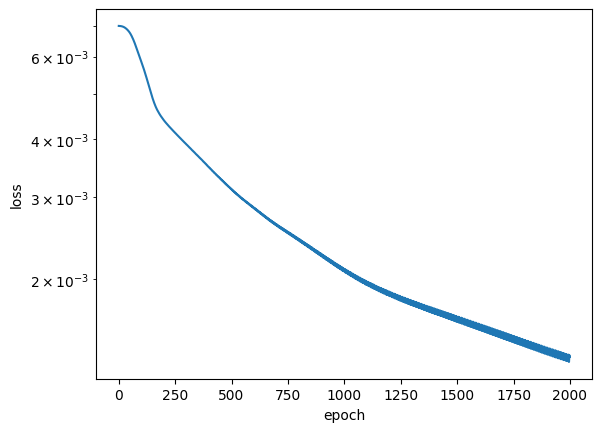

In [188]:
plt.plot(ANN_train.loss_list[0:], label="ANN with current history")
# plt.plot(ANN_train_no_current.loss_list[0:], label="ANN without current history")
plt.yscale("log")
plt.ylabel("loss")
plt.xlabel("epoch")

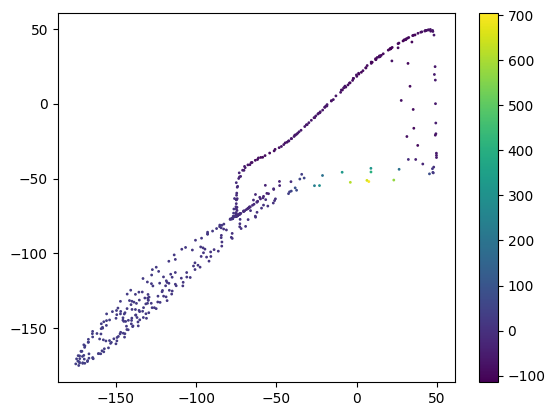

In [189]:
"""centers in the time delay space. The color represents RBFs contribution to the dynamics"""

plot_start = 0 
plot_end = -1
def get_distances_to_centers(x):
    diff = kmeans.cluster_centers_ - x
    dist = jnp.exp(-np.sum(diff**2, axis=-1)*R/2)
    return dist
dist = jax.vmap(get_distances_to_centers, in_axes=0)(kmeans.cluster_centers_)

# plt.plot(points_time_delay[:, 1], points_time_delay[:, 0], linewidth=1)
plt.scatter(kmeans.cluster_centers_[:, -1][plot_start:plot_end], kmeans.cluster_centers_[:, -2][plot_start:plot_end], c=(dist@w)[plot_start:plot_end], s=1)
# plt.scatter(kmeans.cluster_centers_[:, -1][plot_start:plot_end], kmeans.cluster_centers_[:, -2][plot_start:plot_end], c=np.clip((dist@w)[plot_start:plot_end], a_min=-30, a_max=10), s=1)
plt.colorbar()
# plt.xlim(-85, -40)
# plt.ylim(-85, -40)

In [190]:
points_time_delay.shape

(24820, 10)

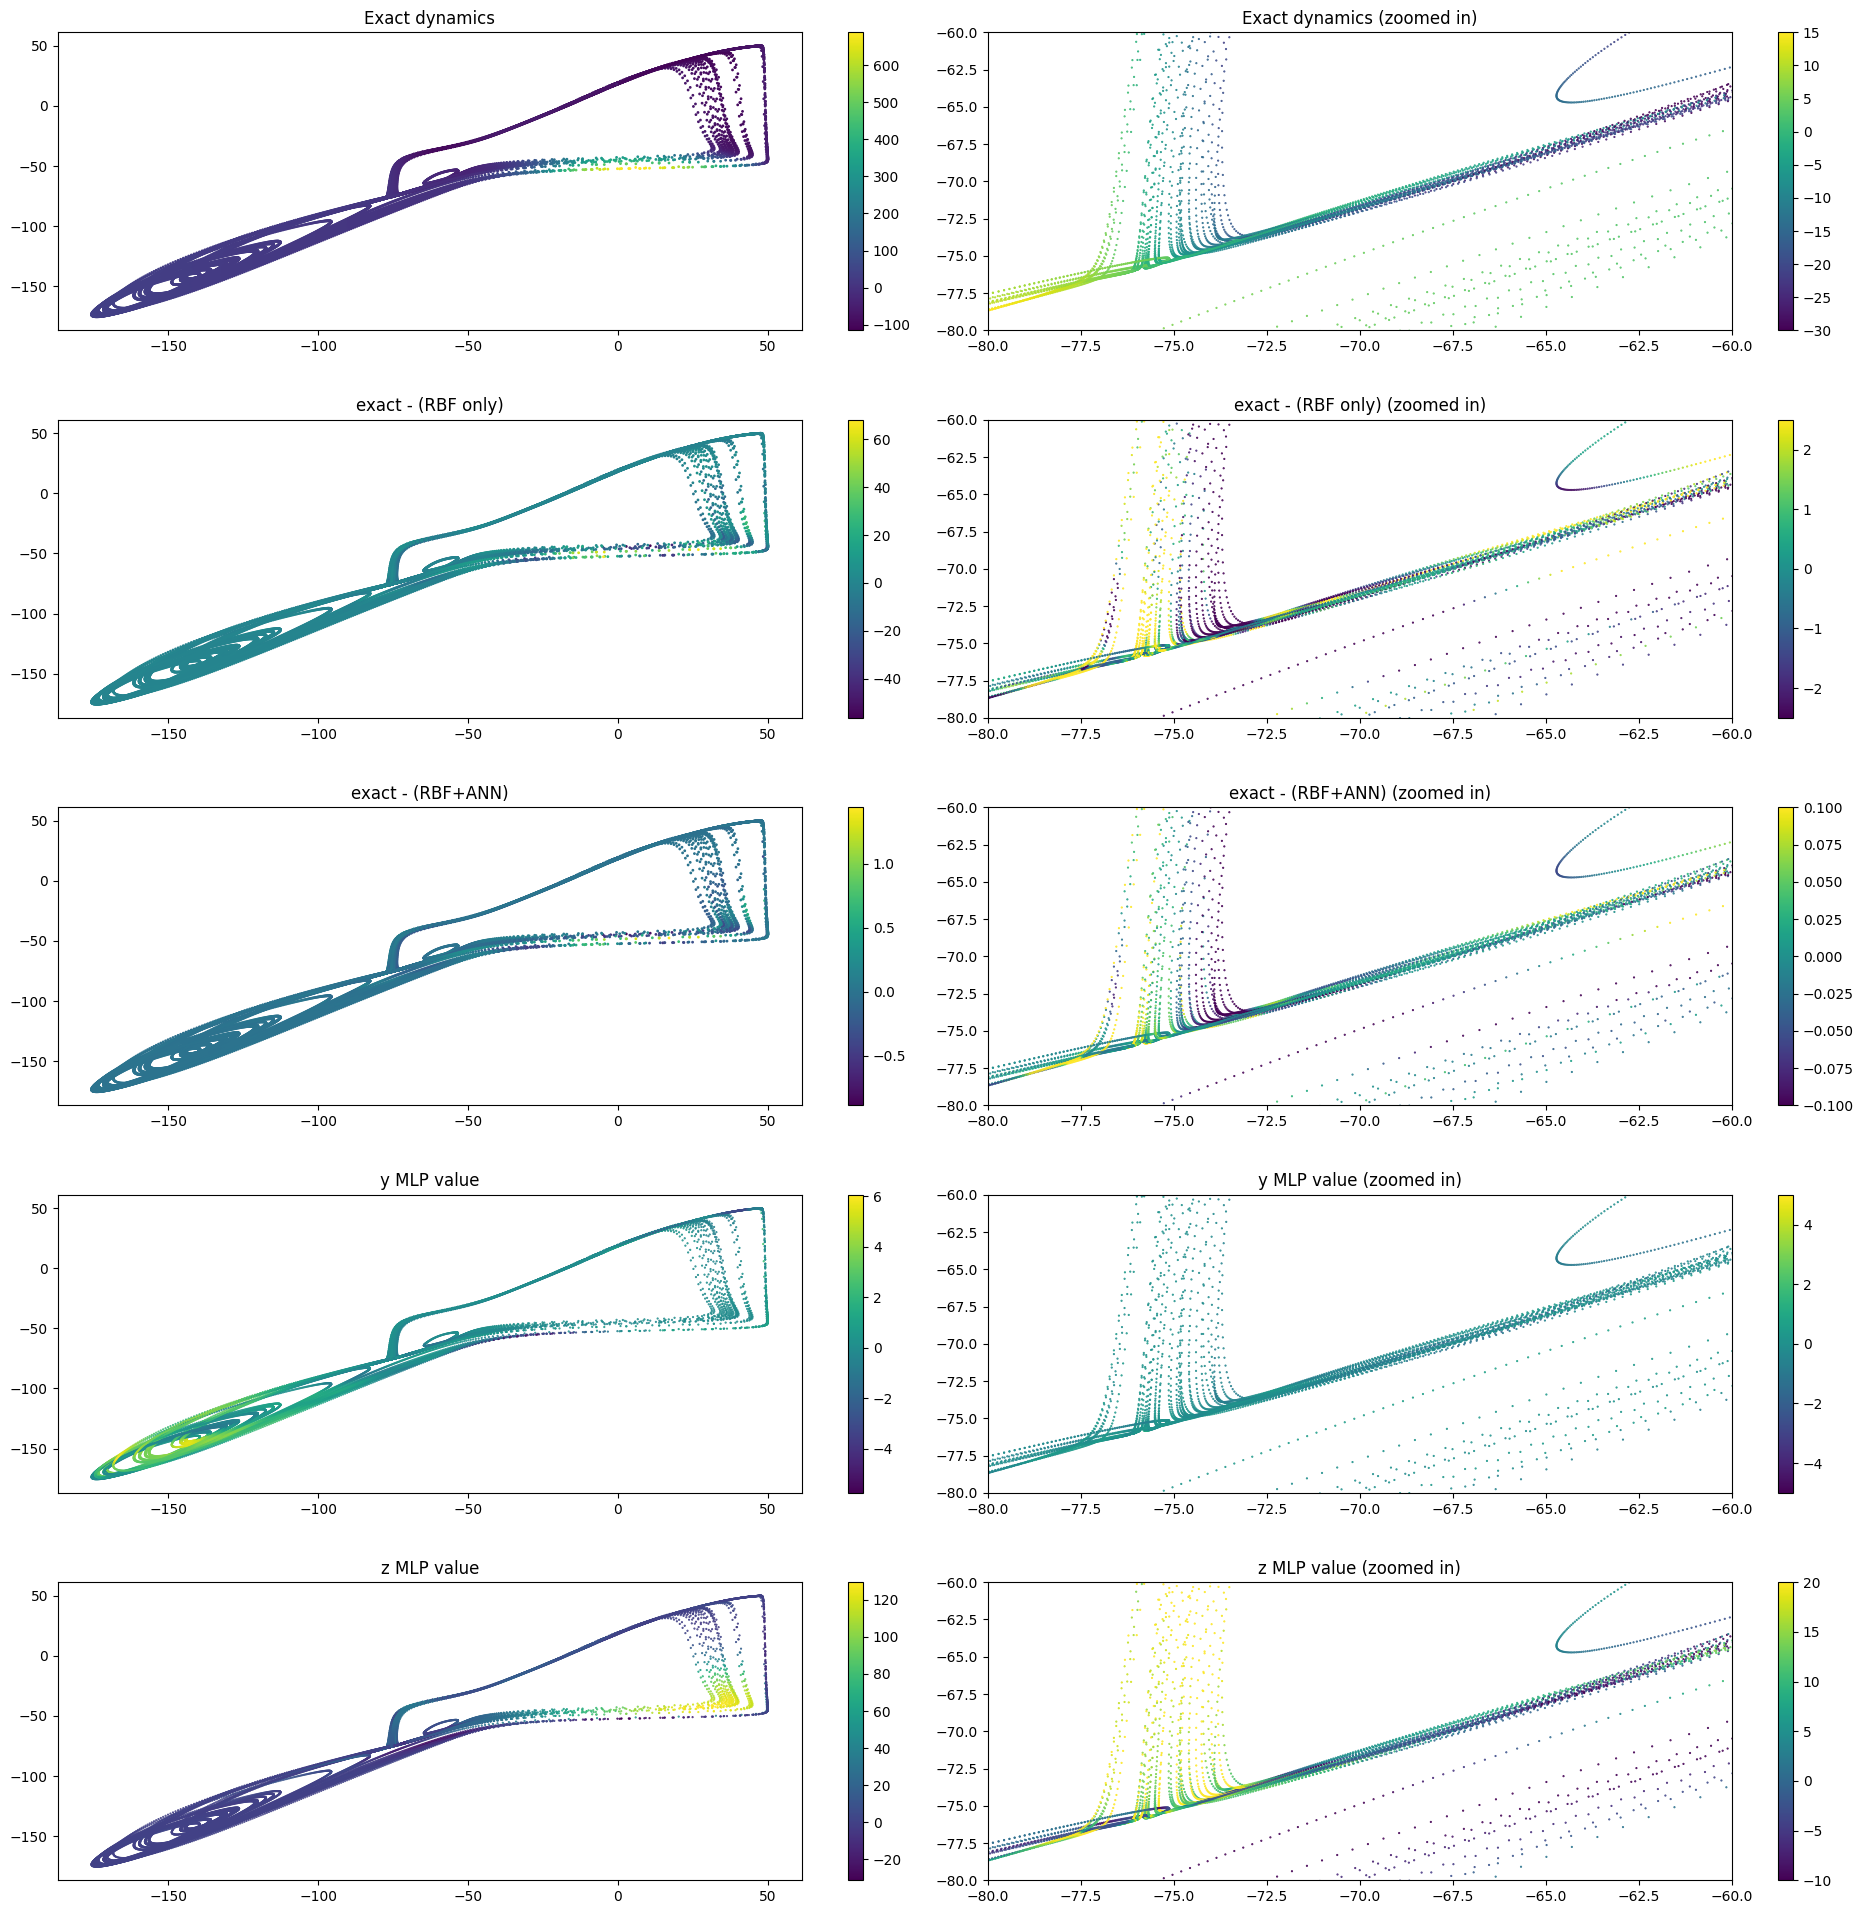

In [191]:
"""data points in the time delay space. The color represents RBFs contribution to the dynamics"""

fig, axes = plt.subplots(5, 2,  figsize=(24, 24))
fig.subplots_adjust(hspace=0.3, wspace=0.)

zoomed_x_range = (-80, -60)
zoomed_y_range = (-80, -60)

# Plot exact dynamics
# x = training_neuron.sol[time_delay:, 0]
# y = training_neuron.sol[:-time_delay, 0]
x = points_time_delay[:, -1]
xf = points_time_delay[:, -2]
dx = x[1:] - x[:-1]
dx[-1] = 0
# i = stimulus.stimulus_list[time_delay:]
i = stimulus.stimulus_list[time_delay*(time_delay_dim-1):]
avg_i = (i[:-1]+i[1:])/2
dx = dx/time_range[2] - avg_i
im = axes[0, 0].scatter(x[:-1], xf[:-1], c=dx[:], s=1)
axes[0, 0].set_title("Exact dynamics")
fig.colorbar(im, ax=axes[0, 0])

# Plot exact dynamics (zoomed in)
im = axes[0, 1].scatter(x[:-1], xf[:-1], c=np.clip(dx[:], a_min=-30, a_max=15), s=0.3)
axes[0, 1].set_xlim(zoomed_x_range)
axes[0, 1].set_ylim(zoomed_y_range)
axes[0, 1].set_title("Exact dynamics (zoomed in)")
fig.colorbar(im, ax=axes[0, 1])

# Plot exact - (RBF only) 
dist = jax.vmap(get_distances_to_centers, in_axes=0)(points_time_delay[:-1])
im = axes[1, 0].scatter(points_time_delay[:-1][plot_start:plot_end, -1], points_time_delay[:-1][plot_start:plot_end, -2], c=(dx - dist@w)[plot_start:plot_end], s=1)
axes[1, 0].set_title("exact - (RBF only)")
fig.colorbar(im, ax=axes[1, 0])

# Plot exact - (RBF only) (zoomed in)
im = axes[1, 1].scatter(points_time_delay[:-1][plot_start:plot_end, -1], points_time_delay[:-1][plot_start:plot_end, -2], c=np.clip((dx - dist@w)[plot_start:plot_end], a_min=-2.5, a_max=2.5), s=0.3)
axes[1, 1].set_xlim(zoomed_x_range)
axes[1, 1].set_ylim(zoomed_y_range)
axes[1, 1].set_title("exact - (RBF only) (zoomed in)")
fig.colorbar(im, ax=axes[1, 1])

# Plot exact - (RBF+ANN)
i_time_delay_points = np.array([np.roll(stimulus.stimulus_list[:], -i*time_delay) for i in range(time_delay_dim)]).T
i_time_delay_points = i_time_delay_points[: -time_delay*(time_delay_dim-1)]
avg_i_time_delay_points = (i_time_delay_points[:-1]+i_time_delay_points[1:])/2
xyz_list = pred_model_xyz.apply(params, points_time_delay[:-1], avg_i_time_delay_points)
im = axes[2, 0].scatter(points_time_delay[:-1][plot_start:plot_end, -1], points_time_delay[:-1][plot_start:plot_end, -2], c=((xyz_list[:, 0] + xyz_list[:, 1]*xyz_list[:, 2])/time_range[2] - dist@w)[plot_start:plot_end], s=1)
axes[2, 0].set_title("exact - (RBF+ANN)")
fig.colorbar(im, ax=axes[2, 0])

# Plot exact - (RBF+ANN) (zoomed in)
im = axes[2, 1].scatter(points_time_delay[:-1][plot_start:plot_end, -1], points_time_delay[:-1][plot_start:plot_end, -2], c=np.clip(((xyz_list[:, 0] + xyz_list[:, 1]*xyz_list[:, 2])/time_range[2] - dist@w)[plot_start:plot_end], a_min=-0.1, a_max=0.1), s=0.3)
axes[2, 1].set_xlim(zoomed_x_range)
axes[2, 1].set_ylim(zoomed_y_range)
axes[2, 1].set_title("exact - (RBF+ANN) (zoomed in)")
fig.colorbar(im, ax=axes[2, 1])

# Plot y MLP
im = axes[3, 0].scatter(points_time_delay[:-1][plot_start:plot_end, -1], points_time_delay[:-1][plot_start:plot_end, -2], c=(xyz_list[:, 1]/time_range[2])[plot_start:plot_end], s=0.3)
axes[3, 0].set_title("y MLP value")
fig.colorbar(im, ax=axes[3, 0])

# Plot y MLP (zoomed in)
im = axes[3, 1].scatter(points_time_delay[:-1][plot_start:plot_end, -1], points_time_delay[:-1][plot_start:plot_end, -2], c=np.clip((xyz_list[:, 1]/time_range[2])[plot_start:plot_end], a_min=-5, a_max=5), s=0.3)
axes[3, 1].set_xlim(zoomed_x_range)
axes[3, 1].set_ylim(zoomed_y_range)
axes[3, 1].set_title("y MLP value (zoomed in)")
fig.colorbar(im, ax=axes[3, 1])

# Plot z MLP
im = axes[4, 0].scatter(points_time_delay[:-1][plot_start:plot_end, -1], points_time_delay[:-1][plot_start:plot_end, -2], c=(xyz_list[:, 2]/time_range[2])[plot_start:plot_end], s=0.3)
axes[4, 0].set_title("z MLP value")
fig.colorbar(im, ax=axes[4, 0])

# Plot y MLP (zoomed in)
im = axes[4, 1].scatter(points_time_delay[:-1][plot_start:plot_end, -1], points_time_delay[:-1][plot_start:plot_end, -2], c=np.clip((xyz_list[:, 2]/time_range[2])[plot_start:plot_end], a_min=-10, a_max=20), s=0.3)
axes[4, 1].set_xlim(zoomed_x_range)
axes[4, 1].set_ylim(zoomed_y_range)
axes[4, 1].set_title("z MLP value (zoomed in)")
fig.colorbar(im, ax=axes[4, 1])

In [192]:
class generate_batch_prediction_with_current():
    def __init__(self, model: lib.prediction_model_with_current, time_delay:int, time_delay_dim: int, batch_stimulus_list: Sequence[float], batch_initial_piece: Sequence[float]) -> None:
        """
        the initial_piece should be a sequence of voltages from (t0 - time_delay*(time_delay_dim-1)) to t0. (the length of this sequence is time_delay*(time_delay_dim-1)+1)
        the stimulus list should also starts at (t0 - time_delay*(time_delay_dim-1))
        """
        self.model = model
        self.time_delay, self.time_delay_dim = time_delay, time_delay_dim
        self.batch_avg_i = ((batch_stimulus_list + jnp.roll(batch_stimulus_list, -1, axis=-1))/2)[..., :-1]
        self.batch_initial_piece = batch_initial_piece
        prediction_list_shape = list(self.batch_avg_i.shape)
        prediction_list_shape[-1] += 1
        self.prediction_list = np.zeros(prediction_list_shape)
        self.prediction_list[..., :batch_initial_piece.shape[-1]] = batch_initial_piece

    def run(self, params, n_steps=None):
        # initial_piece_len = self.time_delay*(self.time_delay_dim-1)+1
        initial_piece_len = self.batch_initial_piece.shape[-1]
        state_indices = np.array([n*self.time_delay for n in range(self.time_delay_dim)]) 
        if n_steps is not None:
            n_steps = min(n_steps, self.prediction_list.shape[-1] - initial_piece_len)
        for i in tqdm(range(n_steps)):
            vs = jnp.array(self.prediction_list[..., state_indices])
            avg_is = jnp.array(self.batch_avg_i[..., state_indices])
            next_v = self.model.apply(params, vs, avg_is)
            self.prediction_list[..., i+initial_piece_len] = next_v
            state_indices = state_indices + 1

In [193]:
"""data prepartion for prediction"""
initial_piece_len = time_delay*(time_delay_dim-1) + 1
prediction_start_after = 1100

# training data set
initial_piece_training = training_neuron.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_training = stimulus.stimulus_list[prediction_start_after+initial_piece_len:]

# test data set
stimulus_test = lib.lorenz1963_stimulus(time_range=time_range, initial_state=[-3.3, -3.0, 22], rescale_factor=rescale_factor)
# stimulus_test = lib.constant_stimulus(dc_stimulus=10, time_range=time_range)
stimulus_test.get_stimulus_list()
test_neuron = lib.single_neuron_odeint(stimulus_test, [-10, 0, 0.8, 0.5])
test_neuron.generate_sol()
test_neuron.sol = test_neuron.sol[drop_first_n_points:]
stimulus_test.stimulus_list = stimulus_test.stimulus_list[drop_first_n_points:]
initial_piece_test = test_neuron.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test = stimulus_test.stimulus_list[prediction_start_after+initial_piece_len:]

batch_initial_piece = jnp.array([initial_piece_training, initial_piece_test])
batch_stimulus_list = jnp.array([stimulus_list_training, stimulus_list_test])

In [194]:
"""prediction with ann + current history"""
pred_run1_batch = generate_batch_prediction_with_current(pred_model1, time_delay, time_delay_dim, batch_stimulus_list, batch_initial_piece)
pred_run1_batch.run(params, n_steps=20000)

100%|██████████| 20000/20000 [39:22<00:00,  8.47it/s] 


In [195]:
"""prediction without ann"""
intrinsic_model0 = rbf_only_model(time_delay_dim=time_delay_dim, R=R, centers=jnp.array(kmeans.cluster_centers_), weights=w)
pred_model0 = lib.prediction_model_with_current(intrinsic_model0, time_spacing=time_range[-1])

pred_run0_batch = generate_batch_prediction_with_current(pred_model0, time_delay, time_delay_dim, batch_stimulus_list, batch_initial_piece)
params00 = pred_model0.init(jax.random.PRNGKey(0), jnp.zeros((time_delay_dim)), jnp.zeros((time_delay_dim)))
pred_run0_batch.run(params00, n_steps=20000)

100%|██████████| 20000/20000 [08:53<00:00, 37.47it/s]


In [174]:
"""prediction with ann, no current history"""
pred_run2_batch = generate_batch_prediction_with_current(pred_model2, time_delay, time_delay_dim, batch_stimulus_list, batch_initial_piece)
pred_run2_batch.run(params_ANN_no_current, n_steps=6000)

NameError: name 'pred_model2' is not defined

Text(0, 0.5, 'current (pA)')

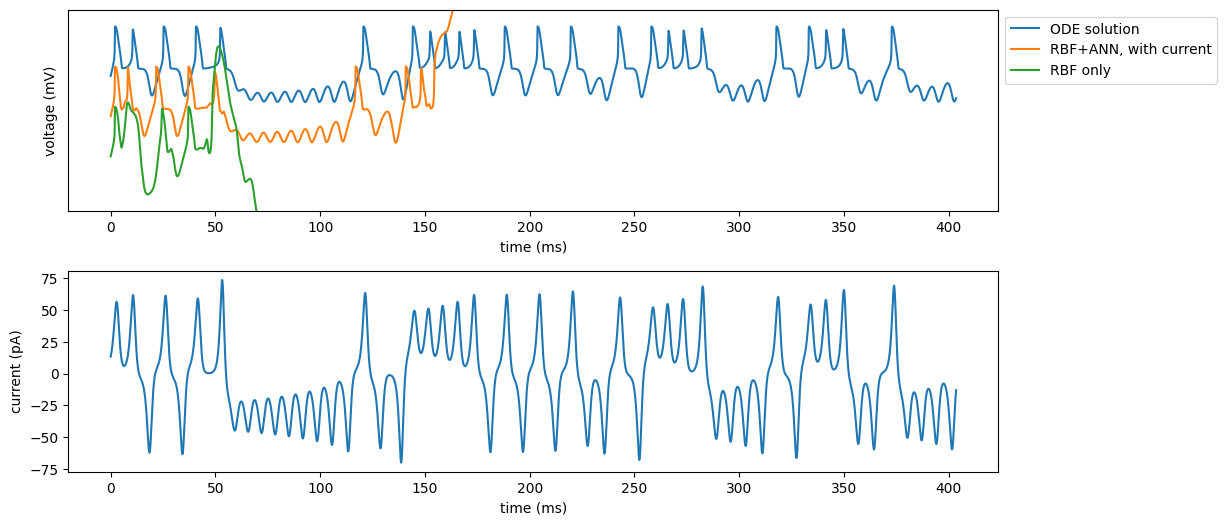

In [196]:
"""plot of prediction based on test neuron and stimulus"""
start = initial_piece_len + -initial_piece_len 
end = initial_piece_len + 20000

fig, axes = plt.subplots(2, 1,  figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes[0].plot(np.arange(0, (end-start)*0.02, 0.02), test_neuron.sol[prediction_start_after+start: prediction_start_after+end, 0]+0, label="ODE solution")
axes[0].plot(np.arange(0, (end-start)*0.02, 0.02), pred_run1_batch.prediction_list[1, start:end]-120, label="RBF+ANN, with current")
# axes[0].plot(np.arange(0, (end-start)*0.02, 0.02), pred_run2_batch.prediction_list[1, start:end]-240, label="RBF+ANN, no current")
axes[0].plot(np.arange(0, (end-start)*0.02, 0.02), pred_run0_batch.prediction_list[1, start:end]-240, label="RBF only")
axes[0].set_yticks([])
axes[0].set_xlabel("time (ms)")
axes[0].set_ylabel("voltage (mV)")
axes[0].set_ylim(-500, 100)
axes[0].legend(bbox_to_anchor=(1,1))

axes[1].plot(np.arange(0, (end-start)*0.02, 0.02), test_neuron.stimulus.stimulus_list[prediction_start_after+start: prediction_start_after+end])
axes[1].set_xlabel("time (ms)")
axes[1].set_ylabel("current (pA)")
# plt.plot(test_neuron.sol[start+prediction_start_after:end+prediction_start_after, 0])

Text(0, 0.5, 'current (pA)')

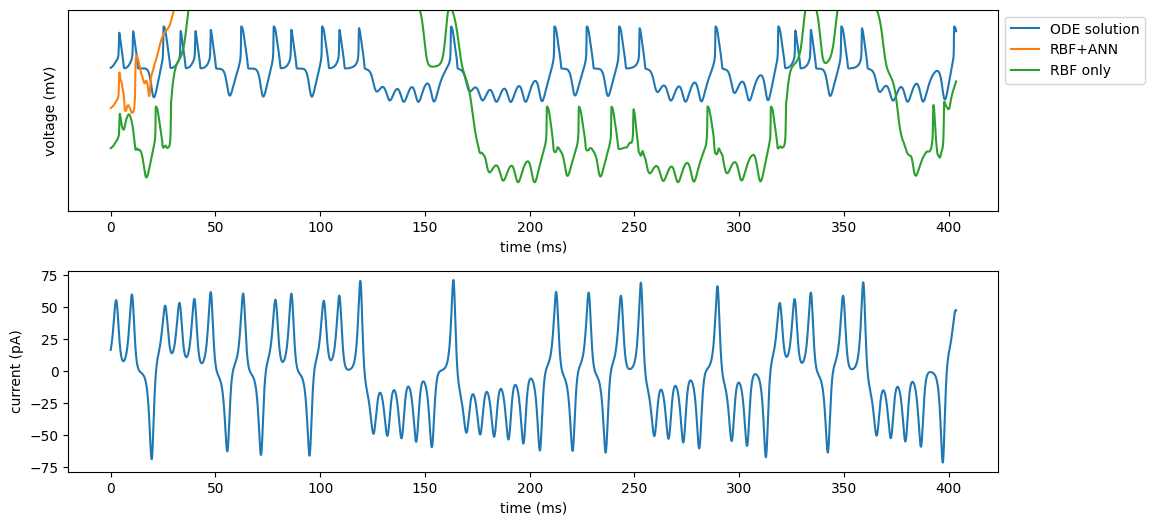

In [197]:
"""plot of prediction based on training neuron and stimulus"""
start = initial_piece_len + -initial_piece_len 
end = initial_piece_len + 20000

fig, axes = plt.subplots(2, 1,  figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes[0].plot(np.arange(0, (end-start)*0.02, 0.02), training_neuron.sol[prediction_start_after+start: prediction_start_after+end, 0]+0, label="ODE solution")
axes[0].plot(np.arange(0, (end-start)*0.02, 0.02), pred_run1_batch.prediction_list[0, start:end]-120, label="RBF+ANN")
# axes[0].plot(np.arange(0, (end-start)*0.02, 0.02), pred_run2_batch.prediction_list[0, start:end]-240, label="RBF+ANN, no current")
axes[0].plot(np.arange(0, (end-start)*0.02, 0.02), pred_run0_batch.prediction_list[0, start:end]-240, label="RBF only")
axes[0].set_yticks([])
axes[0].set_xlabel("time (ms)")
axes[0].set_ylabel("voltage (mV)")
axes[0].set_ylim(-500, 100)
axes[0].legend(bbox_to_anchor=(1,1))

axes[1].plot(np.arange(0, (end-start)*0.02, 0.02), training_neuron.stimulus.stimulus_list[prediction_start_after+start: prediction_start_after+end])
axes[1].set_xlabel("time (ms)")
axes[1].set_ylabel("current (pA)")
# plt.plot(test_neuron.sol[start+prediction_start_after:end+prediction_start_after, 0])

In [70]:
"""save data"""

np.save("plot_data/test_neuron.sol", test_neuron.sol)
np.save("plot_data/test_prediction_rbf_ann_current", pred_run1_batch.prediction_list[1])
np.save("plot_data/test_prediction_rbf_only", test_neuron.sol)

array([[-70.06391907, -69.9960022 , -69.92727661, ...,   0.        ,
          0.        ,   0.        ],
       [-69.68424988, -69.66399384, -69.64407349, ...,   0.        ,
          0.        ,   0.        ]])